In [1]:
#import warnings
#warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      '| device num:', os.environ['CUDA_VISIBLE_DEVICES'])

/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorflow/

available GPU devices: 1  | device num: 0


/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/mrorangeenv/lib/python3.7/site

In [2]:
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
CUT_DATE = '2015-10-24'
END_DATE = '2016-04-24'
print(datetime.strptime(END_DATE, '%Y-%m-%d'))
LOOK_BACK = 2 * 28
LOOK_FWD = 28
BATCH_SIZE = 1000

2016-04-24 00:00:00


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int16', 
    'month':            'int16', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int16', 
    'snap_TX':          'int16', 
    'snap_WI':          'int16'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float32'
}

In [4]:
def get_df(is_train=True, backward_lags=None):
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    cat_cols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    last_day = int(strain.columns[-1].replace('d_', ''))
    print('last day is:', last_day)
    if not is_train:
        for day in range(last_day + 1, last_day + 28 + 28 + 1):
            strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = cat_cols,
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    print('calendar merge done')
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    strain = strain.merge(
        sprices, 
        on=['store_id', 'item_id', 'wm_yr_wk'], 
        copy=False
    )
    print('prices merge done')
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    if not is_train:
        strain = strain.loc[
            strain['date'] >= (datetime.strptime(END_DATE, '%Y-%m-%d') - timedelta(days=backward_lags))
        ]
    else:
        strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    date_features = {
        'week_num': 'weekofyear',
        'quarter': 'quarter',
        'mday': 'day'
    }
    for date_feat_name, date_feat_func in date_features.items():
        strain[date_feat_name] = getattr(strain['date'].dt, date_feat_func).astype('int16')
    print('date features done')
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    drop_cols = ['date', 'wm_yr_wk', 'weekday']
    strain.drop(columns=drop_cols, inplace=True)
    strain.sort_values(by=['id', 'd'], inplace=True)
    print('trash cols deleted, sorted')
    strain['d_'] = strain['d']
    print('out dataframe:', strain.shape)
    return strain

In [5]:
def get_dummies(strain, cols_dummy):
    print('got shape for dummies:', strain.shape)
    strain_dummies = pd.get_dummies(
        strain[cols_dummy],
        drop_first=False,
        dummy_na=True
    )
    strain.drop(columns=cols_dummy, inplace=True)
    strain = pd.concat([strain, strain_dummies], axis=1)
    print('out shape for dummies:', strain.shape)
    return strain

In [6]:
%%time
strain = get_df(is_train=True, backward_lags=None)

read train: (30490, 1919)
last day is: 1913
melted train: (58327370, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-04-24 00:00:00
date cut train: (5607717, 22)
cut train date: 2015-10-24 00:00:00
end train date: 2016-04-24 00:00:00
date features done
trash cols deleted, sorted
out dataframe: (5607717, 23)
CPU times: user 40.5 s, sys: 6.54 s, total: 47 s
Wall time: 47 s


In [7]:
num_cols = ['d', 'sales', 'wday', 'month', 'year', 
            'snap_CA', 'snap_TX', 'snap_WI', 
            'sell_price', 'week_num', 'quarter', 'mday']
SCALER = MinMaxScaler()
strain[num_cols] = SCALER.fit_transform(strain[num_cols])
print('min-max scaled')

min-max scaled


In [8]:
sval = strain[strain.d_ >= (1913 - LOOK_BACK - LOOK_FWD)]
print('val | start:', sval.d_.min(), 
      'end:', sval.d_.max(),
      'duration:', sval.d_.max() - sval.d_.min(), 
      'deep:', LOOK_BACK + LOOK_FWD)
strain = strain[strain.d_ <= (1913 - LOOK_FWD)]
print('train | start:', strain.d_.min(), 
      'end:', strain.d_.max(),
      'duration:', strain.d_.max() - strain.d_.min(), 
      'deep:', LOOK_BACK + LOOK_FWD)
event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
sdummies_id = strain.drop(columns=num_cols + event_cols + ['d_'])
#strain.drop(columns=['d_'], inplace=True)
#sval.drop(columns=['d_'], inplace=True)
sdummies_id.drop_duplicates(inplace=True)
print('dummies df done:', sdummies_id.shape)
for col in sdummies_id.columns:
    print('dummies:', col, sdummies_id[col].unique().shape)

val | start: 1829 end: 1913 duration: 84 deep: 84
train | start: 1730 end: 1885 duration: 155 deep: 84
dummies df done: (30490, 6)
dummies: id (30490,)
dummies: item_id (3049,)
dummies: dept_id (7,)
dummies: store_id (10,)
dummies: cat_id (3,)
dummies: state_id (3,)


In [9]:
%%time
cols_dummy = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
cols_features = ['d', 'wday', 'month', 'year', 
                 'snap_CA', 'snap_TX', 'snap_WI', 
                 'sell_price', 'week_num', 'quarter', 'mday']
sdummies_id = get_dummies(sdummies_id, cols_dummy)

got shape for dummies: (30490, 6)
out shape for dummies: (30490, 3078)
CPU times: user 228 ms, sys: 12 ms, total: 240 ms
Wall time: 237 ms


In [10]:
def get_sequence_batch(df, dummies, col_id, col_look, look_back, look_fwd, cols_features):
    X, y = [], [] 
    for idx in list(df['id'].unique()):
        for i in range(len(df.loc[df[col_id] == idx, col_look]) - look_back - look_fwd):
            temp_X = []
            temp_X.append(df.loc[df[col_id] == idx, col_look][i : i + look_back])
            for col in cols_features:
                temp_X.append(df.loc[df[col_id] == idx, col][i + look_fwd : i + look_back + look_fwd])
            temp_D = np.array([dummies.loc[dummies[col_id] == idx].values[0][1:]] * look_back).T
            temp_X = np.vstack((temp_X, temp_D))
            X.append(temp_X)
            y.append(df.loc[df[col_id] == idx, col_look][i + look_back : i + look_back + look_fwd])
    X = [x.T for x in np.array(X)] # to feed LSTM with shape as [samples, time steps, features]
    return np.array(X), np.array(y)

In [11]:
def SeqGenerator(df, dummies, col_id, col_look, look_back, look_fwd, cols_features, batch_size):
    while True:
        for i in range(len(df) // batch_size):
            if (i + 1) * batch_size > len(df):
                yield get_sequence_batch(
                    df[i * batch_size:], 
                    dummies,
                    col_id, 
                    col_look, 
                    look_back, 
                    look_fwd, 
                    cols_features
                )
            else:
                yield get_sequence_batch(
                    df[i * batch_size : (i + 1) * batch_size], 
                    dummies,
                    col_id, 
                    col_look, 
                    look_back, 
                    look_fwd, 
                    cols_features
                )

In [12]:
%%time
X, y = next(
    SeqGenerator(
        df=strain, 
        dummies=sdummies_id, 
        col_id='id', 
        col_look='sales', 
        look_back=LOOK_BACK, 
        look_fwd=LOOK_FWD, 
        cols_features=cols_features, 
        batch_size=BATCH_SIZE
    )
)
print(X.shape, y.shape)

(432, 56, 3089) (432, 28)
CPU times: user 3.28 s, sys: 356 ms, total: 3.64 s
Wall time: 3.63 s


In [13]:
print('batches in train:', len(strain) // BATCH_SIZE + 1)
print('batches in val:', len(sval) // BATCH_SIZE + 1)

batches in train: 4754
batches in val: 2592


In [14]:
n_features = 3089
model = Sequential()
model.add(LSTM(units=512, input_shape=(LOOK_BACK, n_features), return_sequences=True))
model.add(Dropout(.4))
model.add(LSTM(units=512))
model.add(Dropout(.4))
model.add(Dense(LOOK_FWD))
model.add(Activation('linear'))
adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
model.compile(loss='mse', optimizer=adam)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 56, 512)           7376896   
_________________________________________________________________
dropout (Dropout)            (None, 56, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 28)                14364     
_________________________________________________________________
activation (Activation)      (None, 28)                0         
Tota

In [ ]:
%%time
model_file = '{}/model_{}.h5'.format(MODELS_DIR, MODEL_VER)
modelsaver = ModelCheckpoint(
    model_file, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True,
    mode='min'
)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit_generator(
    SeqGenerator(
        df=strain, 
        dummies=sdummies_id, 
        col_id='id', 
        col_look='sales', 
        look_back=LOOK_BACK, 
        look_fwd=LOOK_FWD, 
        cols_features=cols_features, 
        batch_size=BATCH_SIZE
    ),
    steps_per_epoch=len(strain) // BATCH_SIZE + 1,
    validation_data=SeqGenerator(
        df=sval, 
        dummies=sdummies_id, 
        col_id='id', 
        col_look='sales', 
        look_back=LOOK_BACK, 
        look_fwd=LOOK_FWD, 
        cols_features=cols_features, 
        batch_size=BATCH_SIZE
    ),
    validation_steps=len(sval) // BATCH_SIZE + 1,
    epochs=100,
    callbacks=[earlystopper, modelsaver],
    verbose=1,
    shuffle=False
)

Epoch 1/100
4753/4754 [============================>.] - ETA: 5s - loss: 8.3953e-05 
Epoch 00001: val_loss improved from inf to 0.00011, saving model to ./models/model_v0.h5
4754/4754 [==============================] - 25303s 5s/step - loss: 8.3941e-05 - val_loss: 1.0921e-04
Epoch 2/100
4753/4754 [============================>.] - ETA: 5s - loss: 8.1322e-05 
Epoch 00002: val_loss did not improve from 0.00011
4754/4754 [==============================] - 25296s 5s/step - loss: 8.1307e-05 - val_loss: 1.1801e-04
Epoch 3/100
4753/4754 [============================>.] - ETA: 5s - loss: 7.6786e-05 
Epoch 00003: val_loss did not improve from 0.00011
4754/4754 [==============================] - 26071s 5s/step - loss: 7.6772e-05 - val_loss: 1.1893e-04
Epoch 4/100
1344/4754 [=======>......................] - ETA: 5:01:44 - loss: 1.0158e-04

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [136]:
model_file = '{}/model_{}.h5'.format(MODELS_DIR, MODEL_VER)
model = load_model(model_file)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 56, 512)           7376896   
_________________________________________________________________
dropout (Dropout)            (None, 56, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 28)                14364     
_________________________________________________________________
activation (Activation)      (None, 28)                0         
Total params: 9,490,460
Trainable params: 9,490,460
Non-trainable params: 0
______________________________________________

(11, 56, 3090) (11, 28)


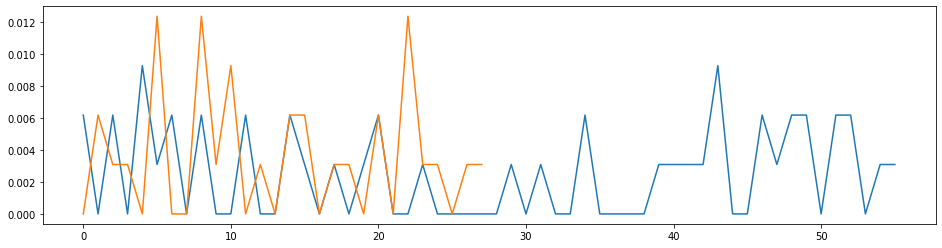

In [18]:
X_val, y_val = next(
    SeqGenerator(
        df=sval, 
        dummies=sdummies_id, 
        col_id='id', 
        col_look='sales', 
        look_back=LOOK_BACK, 
        look_fwd=LOOK_FWD, 
        cols_features=num_cols, 
        batch_size=BATCH_SIZE
    )
)
print(X_val.shape, y_val.shape)
num = 0
plt.figure(figsize=(16, 4))
plt.plot(X_val.T[0][:, num], label='back')
plt.plot(y_val.T[:, num], label='fwd')
plt.show()

In [28]:
def get_sequence_predict(df, pred_len, dummies, col_id, col_look, look_back, look_fwd, cols_features):
    X, temp_X = [], []
    i_end = len(df) - pred_len - look_back - look_fwd - 1
    temp_X.append(df[col_look][i_end : i_end + look_back])
    for col in cols_features:
        temp_X.append(df[col][i_end + look_fwd : i_end + look_back + look_fwd])
    temp_D = np.array([dummies.loc[dummies[col_id] == df.id.values[0]].values[0][1:]] * look_back).T
    temp_X = np.vstack((temp_X, temp_D))
    X.append(temp_X)
    X = [x.T for x in np.array(X)] # to feed LSTM with shape as [samples, time steps, features]
    return np.array(X)
def upscale(series):
    return SCALER.inverse_transform(np.repeat([series], 12, axis=0).T)[:, 1]

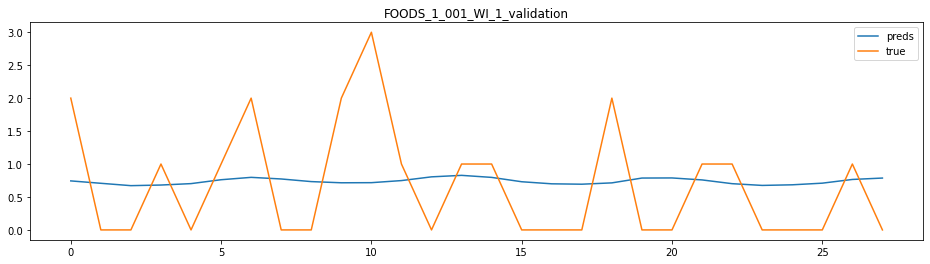

In [37]:
pred_id = strain.id.unique()[7]
X_pred = get_sequence_predict(
    df=strain[strain.id == pred_id], 
    pred_len = 0,
    dummies=sdummies_id, 
    col_id='id', 
    col_look='sales', 
    look_back=LOOK_BACK, 
    look_fwd=LOOK_FWD, 
    cols_features=cols_features
)
preds = model.predict(X_pred)
plt.figure(figsize=(16, 4))
plt.plot(upscale(preds[0]), label='preds')
plt.plot(upscale(sval[sval.id == pred_id]['sales'].values[:28]), label='true')
plt.title(pred_id)
plt.legend()
plt.show()

In [39]:
%%time
spred = get_df(is_train=False, backward_lags=LOOK_BACK)
spred[num_cols] = SCALER.transform(spred[num_cols])
print('min-max scaled')
#spred.drop(columns=['d_'], inplace=True)

read train: (30490, 1919)
last day is: 1913
melted train: (60034810, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-06-19 00:00:00
date cut train: (3445370, 22)
cut train date: 2016-02-28 00:00:00
end train date: 2016-06-19 00:00:00
date features done
trash cols deleted, sorted
out dataframe: (3445370, 23)
min-max scaled
CPU times: user 43 s, sys: 6.94 s, total: 50 s
Wall time: 49.9 s


In [40]:
print('len per one id:', len(spred[(spred.id == 'FOODS_1_001_CA_1_validation')]))
print('unique ids:', len(spred.id.unique()))
print('len forward:', len(spred[(spred.id == 'FOODS_1_001_CA_1_validation') & (spred.d_ > 1913)]))
print('min max day:', spred.d_.min(), spred.d_.max())
spred[spred.d_ >= 1913].head()

113
30490
56
1857 1969


,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week_num,quarter,mday,d_
45978262,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,CA_1,FOODS,CA,1.000000,0.0,0.166667,0.272727,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.065043,0.288462,0.333333,0.766667,1913
45978263,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,CA_1,FOODS,CA,1.005464,NaN,0.333333,0.272727,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.065043,0.307692,0.333333,0.800000,1914
45978264,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,CA_1,FOODS,CA,1.010929,NaN,0.500000,0.272727,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.065043,0.307692,0.333333,0.833333,1915
45978265,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,CA_1,FOODS,CA,1.016393,NaN,0.666667,0.272727,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.065043,0.307692,0.333333,0.866667,1916
45978266,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,CA_1,FOODS,CA,1.021858,NaN,0.833333,0.272727,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.065043,0.307692,0.333333,0.900000,1917


In [45]:
for pred_id in tqdm(spred.id.unique()):
    X_pred = get_sequence_predict(
        df=spred[spred.id == pred_id], 
        pred_len = 28,
        dummies=sdummies_id, 
        col_id='id', 
        col_look='sales', 
        look_back=LOOK_BACK, 
        look_fwd=LOOK_FWD, 
        cols_features=cols_features
    )
    preds = model.predict(X_pred)
    spred.loc[
        (spred.id == pred_id) & 
        (spred.d_ > 1913) & 
        (spred.d_ <= 1913 + 28), 
        'sales'
    ] = upscale(preds[0]) 

/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


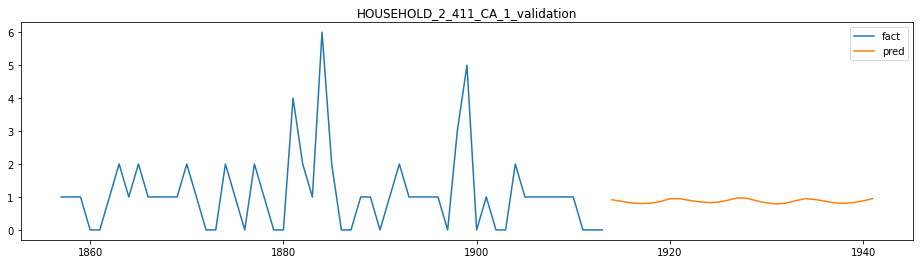

In [135]:
pred_id =  np.random.choice(spred.id.unique())
spred_plt = spred.loc[spred.id == pred_id, ['d_', 'sales']].set_index('d_')
spred_plt.loc[spred_plt.index <= 1913, 'sales'] = upscale(spred_plt[spred_plt.index <= 1913]['sales'])
plt.figure(figsize=(16, 4))
plt.plot(spred_plt[spred_plt.index <= 1913], label='fact')
plt.plot(spred_plt[spred_plt.index > 1913], label='pred')
plt.title(pred_id)
plt.legend()
plt.show()

In [125]:
spred_subm = spred.loc[spred.d_ > 1913, ['id', 'd_', 'sales']].copy()
spred_subm['d_'] = spred_subm['d_'].apply(lambda x: 'F{}'.format(x - 1913))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0
spred_subm.head()

,id,d_,sales
45978263,FOODS_1_001_CA_1_validation,F1,0.915840
45978264,FOODS_1_001_CA_1_validation,F2,0.887936
45978265,FOODS_1_001_CA_1_validation,F3,0.846309
45978266,FOODS_1_001_CA_1_validation,F4,0.846951
45978267,FOODS_1_001_CA_1_validation,F5,0.853231


In [126]:
f_cols = ['F{}'.format(x) for x in range(1, 28 + 1)]
spred_subm = spred_subm.set_index(['id', 'd_']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d_,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.915840,0.887936,0.846309,0.846951,0.853231,0.896160,0.964521,0.958334,0.926973,0.905720,0.882235,0.898691,0.939815,0.987397,0.968169,0.913336,0.876843,0.852523,0.859228,0.916725,0.948941,0.928826,0.888496,0.850013,0.846244,0.860001,0.897595,0.937522
1,FOODS_1_001_CA_2_validation,1.010658,0.974674,0.922380,0.926757,0.941847,0.991177,1.056420,1.054402,1.010821,0.981671,0.956029,0.983631,1.030779,1.078408,1.060063,0.993582,0.945779,0.931179,0.942695,1.006611,1.040076,1.018435,0.970778,0.919638,0.921513,0.944374,0.984380,1.027270
2,FOODS_1_001_CA_3_validation,1.211411,1.136265,1.046470,1.026813,1.042762,1.139734,1.274535,1.259156,1.180295,1.114340,1.061376,1.092580,1.187874,1.300560,1.273436,1.167708,1.068281,1.026831,1.056934,1.169662,1.260599,1.231583,1.146808,1.043639,1.021358,1.052932,1.151574,1.244816
3,FOODS_1_001_CA_4_validation,0.725009,0.712955,0.698743,0.716626,0.721789,0.744011,0.768754,0.769342,0.760438,0.762106,0.756081,0.769118,0.778597,0.787916,0.771806,0.751043,0.738966,0.731675,0.735828,0.755048,0.751948,0.738900,0.724389,0.715272,0.730064,0.731902,0.738223,0.744608
4,FOODS_1_001_TX_1_validation,0.881765,0.858544,0.835336,0.857767,0.864228,0.888532,0.927661,0.922358,0.902841,0.900003,0.887351,0.907568,0.923309,0.947057,0.927247,0.891279,0.875372,0.866549,0.873514,0.905908,0.912835,0.891366,0.866317,0.849450,0.858729,0.867147,0.883223,0.900994


In [127]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
print(spred_subm.shape)
spred_subm.to_csv('submission.csv',index=False)

(60980, 29)
